In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing
from keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from keras.applications.nasnet import NASNetLarge
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, Input, AveragePooling2D
from keras.models import Model
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision, Recall

In [5]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [6]:
import pandas as pd
%cd '/content/drive/MyDrive/ML-Lab/Data/Original/SplitFor1700Images'

/content/drive/.shortcut-targets-by-id/1YMtIXHBBLIQyuH_5uW3lGWVd0F0zsx9N/ML-Lab/Data/Original/SplitFor1700Images


In [7]:
train_df=pd.read_csv('train.csv')

In [8]:
train_df.head()

,Sno,Image,Class
0,1,Mughal/kabulibaghmosqueinpanipat8.jpeg,Mughal
1,2,Mughal/3.jpg,Mughal
2,3,Mughal/tajulmasjidinbhopal4.jpeg,Mughal
3,4,Mughal/tajulmasjidinbhopal9.jpeg,Mughal
4,5,Mughal/TombofItimadUdDaulah15.jpeg,Mughal


In [9]:
train_df['Class'].value_counts()

MaruGurjara    181
Kalinga        173
Chola          172
Mughal         160
Hoysala        160
Tibetan        152
Kerala         152
Cave-Arch      151
Rajput         134
Name: Class, dtype: int64

In [10]:
img=image.load_img('/content/drive/MyDrive/ML-Lab/Data/Original/SplitFor1700Images/train/Mughal/tajmahal3.jpg')
img=image.img_to_array(img)/255

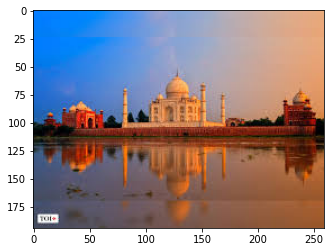

In [11]:
plt.imshow(img)

In [12]:
print(img.shape)

(194, 259, 3)


In [13]:
train_df['Kfold']=-1
train_df.head()

,Sno,Image,Class,Kfold
0,1,Mughal/kabulibaghmosqueinpanipat8.jpeg,Mughal,-1
1,2,Mughal/3.jpg,Mughal,-1
2,3,Mughal/tajulmasjidinbhopal4.jpeg,Mughal,-1
3,4,Mughal/tajulmasjidinbhopal9.jpeg,Mughal,-1
4,5,Mughal/TombofItimadUdDaulah15.jpeg,Mughal,-1


In [14]:
train_df=train_df.sample(frac=1).reset_index(drop=True)
train_df.tail()

,Sno,Image,Class,Kfold
1430,44,Mughal/tombofjahangir0.jpeg,Mughal,-1
1431,1179,MaruGurjara/RanakpurJainTemple31.jpeg,MaruGurjara,-1
1432,118,Mughal/images (7).jpg,Mughal,-1
1433,1033,Kerala/keralastylechurch25.jpeg,Kerala,-1
1434,549,Hoysala/Hoysala8.jpg,Hoysala,-1


In [15]:
y=train_df['Class']

In [16]:
kf=StratifiedKFold(n_splits=5)

In [17]:
for f,(t_,v_) in enumerate(kf.split(X=train_df,y=y)):
  train_df.loc[v_,'Kfold']=f

In [18]:
train_df.head()

,Sno,Image,Class,Kfold
0,1403,Cave-Arch/Bedse18.jpg,Cave-Arch,0
1,942,Tibetan/NyethangDrolmaTemple14.jpeg,Tibetan,0
2,116,Mughal/tajmahal5.jpg,Mughal,0
3,20,Mughal/JodhaBaisPalace15.png,Mughal,0
4,815,Tibetan/t3.jpg,Tibetan,0


In [19]:
train=train_df[train_df['Kfold']!=4]
valid=train_df[train_df['Kfold']==4]

In [20]:
valid.tail()

,Sno,Image,Class,Kfold
1430,44,Mughal/tombofjahangir0.jpeg,Mughal,4
1431,1179,MaruGurjara/RanakpurJainTemple31.jpeg,MaruGurjara,4
1432,118,Mughal/images (7).jpg,Mughal,4
1433,1033,Kerala/keralastylechurch25.jpeg,Kerala,4
1434,549,Hoysala/Hoysala8.jpg,Hoysala,4


In [21]:
valid['Class'].value_counts()

MaruGurjara    36
Chola          35
Kalinga        35
Mughal         32
Hoysala        32
Kerala         31
Tibetan        30
Cave-Arch      30
Rajput         26
Name: Class, dtype: int64

In [22]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator=train_datagen.flow_from_dataframe(dataframe=train,
                                            directory="train",
                                            x_col="Image",
                                            y_col="Class",
                                            subset="training",
                                            batch_size=128,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(331,331))

Found 1142 validated image filenames belonging to 9 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 6 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [23]:
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=valid,
                                            directory="train",
                                            x_col="Image",
                                            y_col="Class",
                                            subset="training",
                                            batch_size=128,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(331,331))

Found 285 validated image filenames belonging to 9 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [24]:
nasnet=NASNetLarge(include_top=True,weights='imagenet')

359759872/359748576 [==============================] - 2s 0us/step


In [25]:
x=nasnet.layers[-2].output
x = Flatten(name='flatten')(x)
x = Dense(512, activation='swish', name='dense_1', kernel_initializer='he_uniform')(x)
x = Dropout(0.1)(x)
fc1=Dense(9, kernel_regularizer=tf.keras.regularizers.l2(0.02),activation='softmax')(x)
my_model=Model(inputs=nasnet.input,outputs=fc1)
adam=Adam(learning_rate=0.0001)

In [26]:
csv_logger = CSVLogger('/content/drive/MyDrive/ML-Lab/EpochLogs/CNN-SVM/Version4.csv')

In [27]:
for l in my_model.layers[:-5]:
    #print(l)
    l.trainable = False
my_model.compile(optimizer=adam,loss ='squared_hinge',metrics=["accuracy",Precision(), Recall()])

In [28]:
my_model.fit_generator(train_generator,steps_per_epoch=len(train.index)//128,validation_data=valid_generator,
                       validation_steps=len(valid.index)//128,epochs=20, callbacks=[csv_logger])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
8/8 [==============================] - 440s 51s/step - loss: 1.5218 - accuracy: 0.3107 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4955 - val_accuracy: 0.5195 - val_precision: 1.0000 - val_recall: 0.0273
Epoch 2/20
8/8 [==============================] - 38s 5s/step - loss: 1.4774 - accuracy: 0.5602 - precision: 0.9359 - recall: 0.0720 - val_loss: 1.4515 - val_accuracy: 0.5430 - val_precision: 0.9020 - val_recall: 0.1797
Epoch 3/20
8/8 [==============================] - 40s 5s/step - loss: 1.4357 - accuracy: 0.5828 - precision: 0.9453 - recall: 0.2554 - val_loss: 1.4192 - val_accuracy: 0.5742 - val_precision: 0.8571 - val_recall: 0.3047
Epoch 4/20
8/8 [==============================] - 41s 5s/step - loss: 1.4039 - accuracy: 0.6114 - precision: 0.8462 - recall: 0.3580 - val_loss: 1.3946 - val_accuracy: 0.6289 - val_precision: 0.8288 - val_recall: 0.3594
Epoch 5/20
8/8 [==============================] - 41s 5s/step - loss: 1.3795 - accuracy: 0.6657 - precision: 0

In [29]:
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 165, 165, 96  2592        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 165, 165, 96  384         ['stem_conv1[0][0]']             
                                )                                                             

In [30]:
my_model.save('model.h5')

In [31]:
try:
  %cd '/content/drive/MyDrive/ML-Lab/SplitFor1700Images'
  my_model = tf.keras.models.load_model('model.h5')
except:
  print('Already done')

[Errno 2] No such file or directory: '/content/drive/MyDrive/ML-Lab/SplitFor1700Images'
/content/drive/.shortcut-targets-by-id/1YMtIXHBBLIQyuH_5uW3lGWVd0F0zsx9N/ML-Lab/Data/Original/SplitFor1700Images


In [32]:
test = pd.read_csv('val.csv')

In [33]:
from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_dataframe(dataframe=test,
                                            directory="val",
                                            x_col="Image",
                                            y_col="Class",
                                            subset="training",
                                            batch_size=128,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(331,331))

Found 363 validated image filenames belonging to 9 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [34]:
test.head()

,Sno,Image,Class
0,1,Mughal/wazirkhanmosque1.jpeg,Mughal
1,2,Mughal/tajulmasjidinbhopal17.png,Mughal
2,3,Mughal/tomb of mariam-uz-zamani5.jpg,Mughal
3,4,Mughal/download (16).jpg,Mughal
4,5,Mughal/images (11).jpg,Mughal


In [35]:
a = my_model.evaluate_generator(test_generator, len(test.index)//128)
print(a)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[1.2344475984573364, 0.76171875, 0.8428571224212646, 0.69140625]


In [36]:
print(f'Accuracy: {a[1]}')
print(f'Precision: {a[2]}')
print(f'Recall: {a[3]}')

Accuracy: 0.76171875
Precision: 0.8428571224212646
Recall: 0.69140625
